### Videos Processing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torchinfo
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [2]:
import torch
import torch.nn as nn

class VideoEmotionRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout):
        super(VideoEmotionRNN, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc_out = nn.Linear(hidden_dim, num_classes)  # Ensure correct dimensions for fc_out
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, mask=None, extract_embeddings=False):
        # x shape: (batch_size, num_frames, input_dim)
        
        lstm_out, (hn, cn) = self.lstm(x)  # lstm_out shape: (batch_size, num_frames, hidden_dim)
        
        if extract_embeddings:
            return lstm_out.mean(dim=1)  # Return embeddings for extraction
        
        # Pooling or selecting the final hidden state
        output = lstm_out.mean(dim=1)  # Average over the time dimension (temporal pooling)
        
        # Pass through the output layer
        output = self.fc_out(output)  # Shape: (batch_size, num_classes)
        output = self.softmax(output)  # Apply softmax for classification
        
        return output


In [3]:
# Data Processing
def preprocess_data(csv_path, max_len=15, input_dim=512):
    # Load the CSV data
    data = pd.read_csv(csv_path)
    
    # Assume 'Counter' column indicates frames and group the features
    feature_columns = [col for col in data.columns if col.startswith('Embedding')]
    
    # Group by 'Counter' to get the frames of each video
    grouped = data.groupby('Counter')
    video_features, video_labels = [], []
    
    for counter, group in grouped:
        features = group[feature_columns].values  # Features for the frames
        label = group['Label'].iloc[0]  # Assuming all frames of a video share the same label
        
        # Apply padding if the number of frames < max_len
        if len(features) < max_len:
            pad_length = max_len - len(features)
            padding = torch.zeros((pad_length, input_dim))  # Padding with zeros
            features = torch.cat((torch.tensor(features), padding), dim=0)
        else:
            features = torch.tensor(features[:max_len])  # Truncate to max_len

        video_features.append(features)
        video_labels.append(label)
    
    # Convert lists to tensors
    video_features = torch.stack(video_features)
    
    # Convert video labels into a tensor (after label encoding)
    label_encoder = LabelEncoder()
    video_labels = torch.tensor(label_encoder.fit_transform(video_labels))
    
    # Print the mapping of original labels to numeric values
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print("Label encoding mapping:")
    for label, numeric in label_mapping.items():
        print(f"{label}: {numeric}")
    
    return video_features, video_labels



In [4]:
# Splitting and DataLoader Preparation
from sklearn.model_selection import train_test_split
def prepare_data_loaders(video_features, video_labels, batch_size, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(video_features, video_labels, test_size=test_size, random_state=42)
    #X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    
    # Create datasets
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
   # validation_dataset = TensorDataset(X_val, y_val)
    
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    #validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [5]:
# from imblearn.over_sampling import SMOTE


# # Function to apply SMOTE and prepare DataLoaders
# def prepare_data_loaders(video_features, video_labels, batch_size, test_size=0.2):
#     # Reshape the video features to 2D (samples, frames * features) for SMOTE
#     num_samples, num_frames, num_features = video_features.shape
#     reshaped_features = video_features.view(num_samples, -1)  # (samples, frames * features)
    
#     # Apply SMOTE to balance the dataset
#     smote = SMOTE(random_state=42)
#     reshaped_features_np = reshaped_features.cpu().numpy()
#     video_labels_np = video_labels.cpu().numpy()
#     X_resampled, y_resampled = smote.fit_resample(reshaped_features_np, video_labels_np)
    
#     # Reshape the resampled features back to 3D (samples, frames, features)
#     X_resampled_3d = torch.tensor(X_resampled).view(-1, num_frames, num_features)
#     y_resampled = torch.tensor(y_resampled)
    
#     # Split the resampled data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X_resampled_3d, y_resampled, test_size=test_size, random_state=42)
#     # print(X_train.shape)
#     # print(y_train.shape)
#     # print(X_test.shape)
#     # Create datasets
#     train_dataset = TensorDataset(X_train, y_train)
#     test_dataset = TensorDataset(X_test, y_test)
    
#     # DataLoaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
#     return train_loader, test_loader


In [6]:
# Training Loop
def train_model(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for video_batch, labels in data_loader:
        video_batch, labels = video_batch.to(device).float(), labels.to(device).long()
       
        # Ensure video_batch is in the correct dtype (float32)
        #video_batch = video_batch.float()  # Convert to torch.float32

        # Generate padding mask
        #padding_mask = generate_padding_mask(video_batch).to(device)

        # Forward pass
        outputs = model(video_batch)

        # Calculate loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return model, avg_loss, accuracy


In [7]:
def test_model(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():  # Disable gradient computation for testing
        for video_batch, labels in data_loader:
            video_batch = video_batch.to(device).float()
            labels = labels.to(device).long()

            # Generate padding mask (if applicable)
            #padding_mask = generate_padding_mask(video_batch).to(device)
            #print(padding_mask)
            
            # Forward pass
            outputs = model(video_batch)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            

    avg_loss = total_loss / len(data_loader)
    accuracy = (correct_predictions / total_samples)

    return avg_loss, accuracy


In [8]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import StratifiedKFold


# Updated cross-validation function
def k_fold_cross_validation(model_class, video_features, video_labels, num_folds, batch_size, num_epochs, learning_rate, device):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    fold_results = []  # To store results for each fold
    # all_embeddings = []  # To store embeddings for all folds
    all_predicted = []
    all_targets = []
    trained_model = None 

    for fold, (train_idx, test_idx) in enumerate(skf.split(video_features, video_labels)):
        print(f"Fold {fold + 1}/{num_folds}")

        # Split data into training and testing for this fold
        X_train, X_test = video_features[train_idx], video_features[test_idx]
        y_train, y_test = video_labels[train_idx], video_labels[test_idx]

        # Apply SMOTE and prepare DataLoaders
        train_loader, test_loader = prepare_data_loaders(X_train, y_train, batch_size)

        model_fold = model_class.to(device)

        # model_fold = VideoEmotionTransformer(
        #     input_dim=input_dim, 
        #     hidden_dim=hidden_dim, 
        #     num_heads=num_heads, 
        #     num_layers=num_layers, 
        #     num_classes=num_classes, 
        #     dropout=dropout,
        #     max_len=max_len
        # ).to(device)

        
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_fold.parameters(), lr=learning_rate)

        # Training and testing loop for the fold
        for epoch in range(num_epochs):
            model_fold, avg_train_loss, accuracy_train = train_model(model_fold, train_loader, criterion, optimizer, device)
            avg_test_loss, accuracy_test = test_model(model_fold, test_loader, criterion, device)
            
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
                  f"Train Accuracy: {accuracy_train * 100:.2f}%, "
                  f"Test Loss: {avg_test_loss:.4f}, "
                  f"Test Accuracy: {accuracy_test * 100:.2f}%, ")

        trained_model = model_fold 

        # # Collect embeddings and true labels for this fold
        # embeddings, targets = get_embeddings(model_fold, test_loader, device)
        # all_embeddings.extend(embeddings)
        # all_targets.extend(targets)
        
        # Collect predictions and true labels for this fold
        predicted, targets = get_predictions(model_fold, test_loader, device)
        all_predicted.extend(predicted)
        all_targets.extend(targets)

        # Store results for this fold
        fold_results.append({
            'fold': fold + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': accuracy_train,
            'test_loss': avg_test_loss,
            'test_accuracy': accuracy_test
        })
    
    #After cross-validation, calculate and print average results across all folds
    avg_train_loss = np.mean([res['train_loss'] for res in fold_results])
    avg_train_accuracy = np.mean([res['train_accuracy'] for res in fold_results])
    avg_test_loss = np.mean([res['test_loss'] for res in fold_results])
    avg_test_accuracy = np.mean([res['test_accuracy'] for res in fold_results])
    
    print("\nCross-validation results:")
    print(f"Average Train Loss: {avg_train_loss:.4f}")
    print(f"Average Train Accuracy: {avg_train_accuracy * 100:.2f}%")
    print(f"Average Test Loss: {avg_test_loss:.4f}")
    print(f"Average Test Accuracy: {avg_test_accuracy * 100:.2f}%")
    
   # Calculate and print performance metrics for the whole cross-validation process
    accuracy = accuracy_score(all_targets, all_predicted)
    f1 = f1_score(all_targets, all_predicted, average='weighted')
    report = classification_report(all_targets, all_predicted)
    conf_matrix = confusion_matrix(all_targets, all_predicted)
    
    print(f"\nFinal Accuracy: {accuracy:.4f}")
    print(f"Final F1 Score: {f1:.4f}")
    print("Classification Report:\n", report)
    
    # Plot confusion matrix
    label_encoder = LabelEncoder()
    label_encoder.fit(video_labels)
    class_labels = label_encoder.classes_
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return trained_model #, fold_results

#Helper function to get predictions from the model
def get_predictions(model, test_loader, device):
    model.eval()
    all_predicted = []
    all_targets = []

    with torch.no_grad():
        for video_batch, labels in test_loader:
            # Move data to device and ensure correct dtype (float32)
            video_batch = video_batch.to(device).float()  # Convert to float32
            labels = labels.to(device)
            
            # Generate padding mask if needed
           # padding_mask = generate_padding_mask(video_batch).to(device)
            
            # Get the model outputs
            outputs = model(video_batch)
            
            # Get the predicted class
            _, predicted = torch.max(outputs, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    return all_predicted, all_targets



In [15]:
# Define model parameters
batch_size = 32
num_epochs = 100
num_folds = 5

input_dim = 512  # Adjust according to your input features
dropout = 0.3
hidden_dim = 256  # Dimension for the hidden layers 256
num_layers = 4   # Number of transformer layers 2
num_classes = 5   # Number of emotion classe
lr = 0.0001         # Learning rate #0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Preprocess data
import pandas as pd
video_features, video_labels = preprocess_data("F:/thesis/Features/Final/Updated/Video_features_final.csv", input_dim=input_dim)

Label encoding mapping:
A: 0
H: 1
L: 2
N: 3
S: 4


In [17]:
video_features.shape

torch.Size([8278, 15, 512])

In [18]:
 # Prepare DataLoaders
#train_data_loader, test_loader = prepare_data_loaders(video_features, video_labels, batch_size=batch_size)

In [19]:
from torchinfo import summary
import torchinfo



# Model, loss function, optimizer
model = VideoEmotionRNN(
    input_dim=input_dim, 
    hidden_dim=hidden_dim, 
    num_layers=num_layers, 
    num_classes=num_classes, 
    dropout = dropout
).to(device)


# Print model summary
torchinfo.summary(model, input_size=(batch_size, num_layers, input_dim))



Layer (type:depth-idx)                   Output Shape              Param #
VideoEmotionRNN                          [32, 5]                   --
├─LSTM: 1-1                              [32, 4, 256]              2,367,488
├─Linear: 1-2                            [32, 5]                   1,285
├─Softmax: 1-3                           [32, 5]                   --
Total params: 2,368,773
Trainable params: 2,368,773
Non-trainable params: 0
Total mult-adds (M): 303.08
Input size (MB): 0.26
Forward/backward pass size (MB): 0.26
Params size (MB): 9.48
Estimated Total Size (MB): 10.00

Fold 1/5
Epoch [1/100], Train Loss: 1.5967, Train Accuracy: 23.64%, Test Loss: 1.5627, Test Accuracy: 27.40%, 
Epoch [2/100], Train Loss: 1.5570, Train Accuracy: 30.77%, Test Loss: 1.5394, Test Accuracy: 34.42%, 
Epoch [3/100], Train Loss: 1.5383, Train Accuracy: 33.34%, Test Loss: 1.5194, Test Accuracy: 34.49%, 
Epoch [4/100], Train Loss: 1.5149, Train Accuracy: 35.15%, Test Loss: 1.5070, Test Accuracy: 37.51%, 
Epoch [5/100], Train Loss: 1.5038, Train Accuracy: 36.38%, Test Loss: 1.4960, Test Accuracy: 37.74%, 
Epoch [6/100], Train Loss: 1.4911, Train Accuracy: 37.66%, Test Loss: 1.4887, Test Accuracy: 38.34%, 
Epoch [7/100], Train Loss: 1.4878, Train Accuracy: 38.57%, Test Loss: 1.4838, Test Accuracy: 39.55%, 
Epoch [8/100], Train Loss: 1.4854, Train Accuracy: 38.61%, Test Loss: 1.4822, Test Accuracy: 40.23%, 
Epoch [9/100], Train Loss: 1.4805, Train Accuracy: 39.27%, Test Loss: 1.4795, Test Accuracy: 39.47%, 
Epoch [10/100], Train Loss: 1.4748, Train Accuracy: 39.80%, Test Loss: 1.

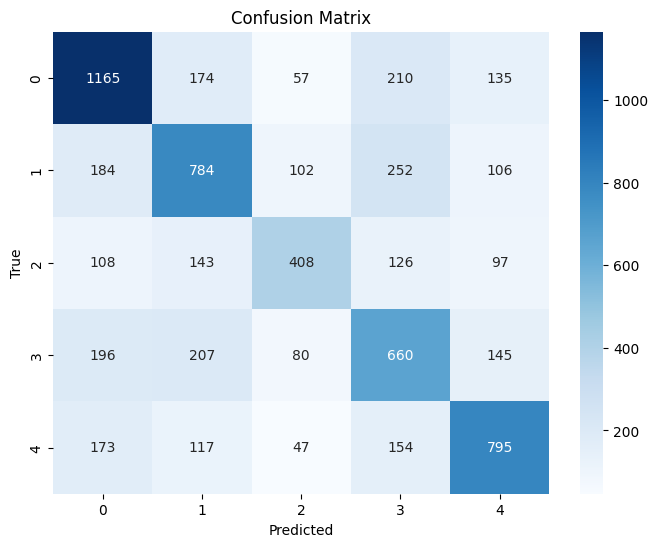

In [20]:
# K-fold cross-validation
model_trained = k_fold_cross_validation(model, video_features, video_labels, num_folds=num_folds, batch_size=batch_size, num_epochs=num_epochs, learning_rate=lr, device=device)

### Extract Embeddings

In [21]:
model_trained = model.to(device).float()  # Ensure model is in Float
model_trained.eval()  # Set the model to evaluation mode


VideoEmotionRNN(
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.3)
  (fc_out): Linear(in_features=256, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

In [22]:
# Preprocess data
video_features, video_labels = preprocess_data("F:/thesis/Features/Final/Updated/Video_features_final.csv",  input_dim=input_dim)

Label encoding mapping:
A: 0
H: 1
L: 2
N: 3
S: 4


In [23]:
video_features.shape

torch.Size([8278, 15, 512])

In [24]:
# Splitting and DataLoader Preparation
def prepare_data_loaders_emb(video_features, video_labels, batch_size):
   
    # Create datasets
    train_dataset = TensorDataset(video_features, video_labels)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    
    return train_loader


In [25]:
 # Prepare DataLoaders
data_loader = prepare_data_loaders_emb(video_features, video_labels, batch_size=batch_size)

In [26]:
all_embeddings = []
all_labels = []

with torch.no_grad():  # No need to compute gradients
    for video_features, labels in data_loader:
        video_features = video_features.to(device).float()  # Convert to Float
        labels = labels.to(device)  # Ensure labels are also on the correct device

        # Extract embeddings
        embeddings = model_trained(video_features, extract_embeddings=True)

        all_embeddings.append(embeddings.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.append(labels.cpu().numpy())  # Collect labels as well

# Concatenate embeddings and labels across all batches
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


In [27]:
# # Print results
# print("\nFold Results:")
# for result in fold_results:
#     print(result)

print("\nExtracted Embeddings Shape:", all_embeddings.shape)
print("Targets Shape:", all_labels.shape)


Extracted Embeddings Shape: (8278, 256)
Targets Shape: (8278,)


In [28]:
all_embeddings

array([[ 0.6489183 , -0.79909265, -0.5329094 , ...,  0.0776611 ,
         0.48417297,  0.3738407 ],
       [ 0.56805545, -0.0415681 , -0.7223535 , ..., -0.01654017,
         0.6530424 ,  0.71960944],
       [ 0.8038553 ,  0.3515537 , -0.9341025 , ...,  0.00646514,
         0.7057449 ,  0.9205134 ],
       ...,
       [-0.53795934, -0.8118899 ,  0.5028423 , ...,  0.70094174,
         0.39786303, -0.76409435],
       [ 0.26699743, -0.82684255, -0.00759993, ...,  0.2264358 ,
        -0.7922018 , -0.76445496],
       [ 0.09611   , -0.76290476, -0.00808759, ...,  0.14839464,
        -0.8209872 , -0.807708  ]], dtype=float32)

In [29]:
import pandas as pd
import numpy as np

# Convert embeddings and targets to numpy arrays if they are not already
all_embeddings = np.array(all_embeddings)
all_targets = np.array(all_labels)

# Ensure that embeddings and targets have the same number of samples
assert all_embeddings.shape[0] == all_targets.shape[0], "Mismatch between number of embeddings and targets"

# Convert embeddings to DataFrame
embeddings_df = pd.DataFrame(all_embeddings)

# Add the targets column
embeddings_df['Target'] = all_targets

# Save the DataFrame to CSV
embeddings_df.to_csv('embeddings_with_targets_RNN.csv', index=False)

print("\nEmbeddings and targets have been saved to 'embeddings_with_targets.csv'.")



Embeddings and targets have been saved to 'embeddings_with_targets.csv'.
